In [2]:
# !pip install -q torch torchvision tqdm matplotlib scikit-image scipy
# !pip install -q grad-cam

In [3]:
# 1) Disable automatic output-scrolling/truncation
from IPython.display import display, HTML
display(HTML("""
<script>
  // prevent Jupyter from collapsing long output
  Jupyter.OutputArea.prototype._should_scroll = function(lines) { return false; }
</script>
"""))

# 2) Make sure your figures appear inline
%matplotlib inline

In [4]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import os
import pickle
from tqdm import tqdm
import random

# PyTorch GradCAM imports
from pytorch_grad_cam import GradCAM as PyTorchGradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
image_size = 32
nc = 3  # Number of channels in the training images
nz = 100  # Size of z latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 10 #150
lr = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
lambda_gradcam = 1.0  # Weight for GradCAM loss 0.5, 0.7, 1.0 are the three options

# Create output directory for results
os.makedirs('results', exist_ok=True)
print('done')

Using device: cuda
done


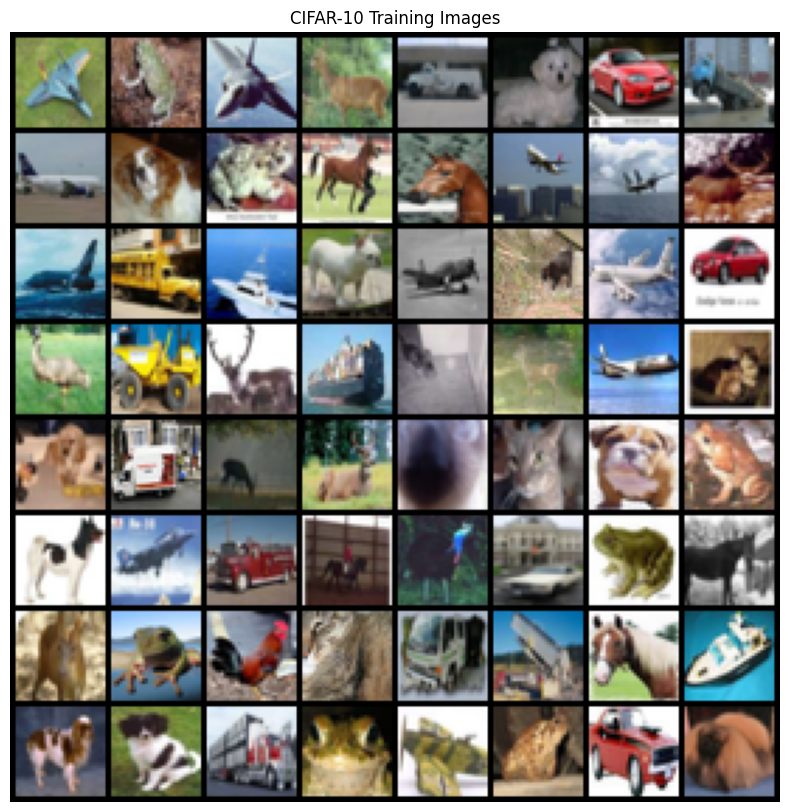

In [5]:
# Data loading
from torch.utils.data import random_split, DataLoader

val_pct = 0.2


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

n_val = int(len(cifar_trainset) * val_pct)
n_train = len(cifar_trainset) - n_val

train_subset, val_subset = random_split(cifar_trainset, [n_train, n_val])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Helper function to display images
def show_images(images, title=None):
    """Display a batch of images"""
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(np.transpose(make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Display some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images[:64], title='CIFAR-10 Training Images')

In [6]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_0", pretrained=True)
print("Loaded Pretrained MobileNetV2 on CIFAR-10!")

model = model.to(device)
model.eval()

# Function to find the last conv layer in MobileNetV2
def get_last_conv_layer(model):
    # Get all modules in the model
    modules = list(model.named_modules())
    
    # Loop through modules in reverse order to find the last conv layer
    for name, module in reversed(modules):
        if isinstance(module, torch.nn.Conv2d):
            print(f"Found last conv layer: {name}")
            return module
    
    # If not found, return the last layer of features
    print("Using last feature layer as fallback")
    return model.features[-1]

# Get the last convolutional layer
last_conv_layer = get_last_conv_layer(model)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Loaded Pretrained MobileNetV2 on CIFAR-10!
Found last conv layer: features.18.0


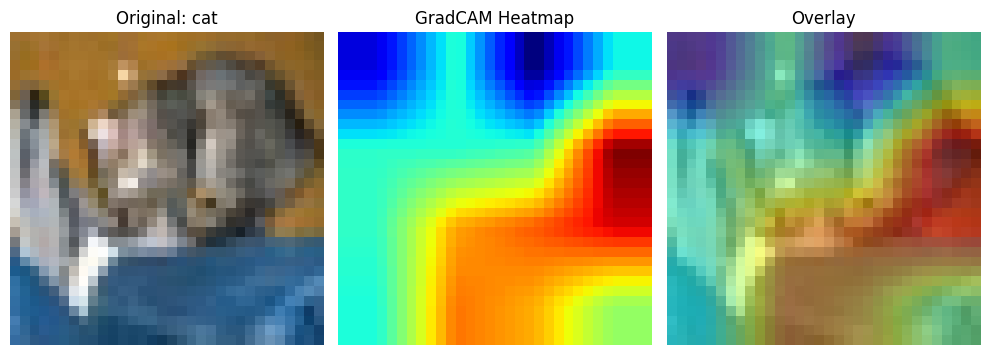

GradCAM test complete!


In [7]:
# Initialize GradCAM with the pre-trained model
# Note: Removed the use_cuda parameter that was causing the error
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(
    model=model,  # Your pre-trained MobileNetV2
    target_layers=[last_conv_layer]  # The last conv layer you identified
)

# Function to generate Grad-CAM heatmaps
def generate_gradcam_heatmap(image, class_idx):
    try:
        # Detach from computation graph before converting to NumPy
        image_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        # Normalize and preprocess for Grad-CAM
        input_tensor = preprocess_image(image_np, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        # Wrap class_idx properly
        target = [ClassifierOutputTarget(class_idx)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]
        return grayscale_cam
    except Exception as e:
        print(f"Error in generate_gradcam_heatmap: {e}")
        # Return a fallback heatmap (uniform distribution)
        return np.ones((32, 32), dtype=np.float32) * 0.5
        
# Function to visualize GradCAM heatmaps
def visualize_gradcam(model, images, labels=None, classes=None):
    """Visualize GradCAM heatmaps for a batch of images"""
    model.eval()
    plt.figure(figsize=(15, 4*len(images)))
    
    for i, image in enumerate(images):
        # Process image
        img_tensor = image.unsqueeze(0).to(device)
        
        # Get prediction if labels not provided
        if labels is None:
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                pred = pred.item()
        else:
            # Just use the label directly - no need to call .item() as we already did that in main()
            pred = labels[i]
        
        # Generate heatmap
        heatmap = generate_gradcam_heatmap(img_tensor, pred)
        
        # Display original image
        plt.subplot(len(images), 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        if classes:
            plt.title(f'Class: {classes[pred]}')
        else:
            plt.title(f'Class: {pred}')
        plt.axis('off')
        
        # Display heatmap
        plt.subplot(len(images), 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('GradCAM Heatmap')
        plt.axis('off')
        
        # Display overlay
        plt.subplot(len(images), 3, i*3+3)
        img_np = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_np)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Test the GradCAM function with a sample image
def test_gradcam():
    # Get a sample image
    test_batch = next(iter(testloader))
    test_image = test_batch[0][0].unsqueeze(0).to(device)
    test_label = test_batch[1][0].item()
    
    # Generate heatmap
    heatmap = generate_gradcam_heatmap(test_image, test_label)
    
    # Display the results
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    img_np = test_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.imshow(img_np)
    plt.title(f'Original: {classes[test_label]}')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("GradCAM test complete!")
    return heatmap

# Function to generate class-specific GradCAM heatmaps
def generate_class_heatmaps(model, dataloader, num_samples=50):
    """Generate and store GradCAM heatmaps for each class"""
    class_heatmaps = {i: [] for i in range(10)}  # 10 classes in CIFAR-10
    
    model.eval()
    count = {i: 0 for i in range(10)}
    
    for data in tqdm(dataloader, desc="Generating class heatmaps"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        for i in range(images.size(0)):
            label = labels[i].item()
            
            if count[label] < num_samples:
                image = images[i:i+1]
                
                # Get prediction
                with torch.no_grad():
                    output = model(image)
                    _, predicted = torch.max(output, 1)
                
                # Only use correctly classified images
                if predicted.item() == label:
                    try:
                        # Generate heatmap
                        heatmap = generate_gradcam_heatmap(image, label)
                        
                        # Convert to tensor
                        heatmap_tensor = torch.from_numpy(heatmap).float().unsqueeze(0).unsqueeze(0)
                        
                        class_heatmaps[label].append(heatmap_tensor)
                        count[label] += 1
                    except Exception as e:
                        print(f"Error generating heatmap: {e}")
                        continue
        
        # Check if we have enough samples for each class
        if all(count[i] >= num_samples for i in range(10)):
            break
    
    print(f"Generated heatmaps: {[len(class_heatmaps[i]) for i in range(10)]}")
    return class_heatmaps
    
# Uncomment to test the GradCAM function
test_result = test_gradcam()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input.view(-1, nz, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # No Sigmoid here, will use BCEWithLogitsLoss
        )

    def forward(self, input):
        return self.main(input)

# Initialize networks
def initialize_networks():
    """Initialize Generator and Discriminator networks"""
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    return netG, netD

In [9]:
# Custom function to compute SSIM loss
def ssim_loss(img1, img2):
    """Compute SSIM loss between two tensors (heatmaps)"""
    # Convert to numpy arrays for SSIM calculation
    img1_np = img1.detach().cpu().numpy().squeeze()
    img2_np = img2.detach().cpu().numpy().squeeze()
    
    # Calculate SSIM
    ssim_value = ssim(img1_np, img2_np, data_range=1.0)
    
    # Return 1 - SSIM as the loss (higher SSIM = lower loss)
    return 1.0 - ssim_value

# Custom function to compute Pearson correlation loss
def pearson_loss(img1, img2):
    """Compute Pearson correlation loss between two tensors (heatmaps)"""
    # Flatten tensors
    img1_flat = img1.view(-1).detach().cpu().numpy()
    img2_flat = img2.view(-1).detach().cpu().numpy()
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(img1_flat, img2_flat)
    
    # Handle NaN values
    if np.isnan(pearson_corr):
        pearson_corr = 0.0
    
    # Return 1 - correlation as the loss (higher correlation = lower loss)
    return 1.0 - pearson_corr

# Function to compute GradCAM region emphasis loss
def gradcam_region_emphasis_loss(real_heatmap, fake_heatmap):
    """Compute combined GradCAM region emphasis loss"""
    # Compute SSIM and Pearson losses
    ssim_l = ssim_loss(real_heatmap, fake_heatmap)
    pearson_l = pearson_loss(real_heatmap, fake_heatmap)
    
    # Return average of both losses
    return 0.5 * (ssim_l + pearson_l)

In [10]:
# GAN Training with GradCAM (5-sample heatmap comparison)
def train_gan_with_gradcam(pretrained_model, class_heatmaps, netG, netD, num_epochs=50):
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    fixed_noise = torch.randn(16, nz, 1, 1, device=device)

    g_losses, d_losses, gc_losses = [], [], []
    val_g_losses, val_d_losses, val_gc_losses = [], [], []

    for epoch in range(num_epochs):
        netG.train()
        netD.train()
        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            real_images, _ = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # ---- Train Discriminator ----
            netD.zero_grad()
            label = torch.full((batch_size,), 1., device=device)
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0.)
            output = netD(fake_images.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ---- Train Generator ----
            netG.zero_grad()
            label.fill_(1.)
            output = netD(fake_images).view(-1)
            errG_gan = criterion(output, label)

            pretrained_model.eval()
            with torch.no_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            gradcam_loss_value = 0.
            valid_count = 0
            for j in range(batch_size):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = torch.from_numpy(hm).float().unsqueeze(0).unsqueeze(0).to(device)

                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm) for r in real_hms]
                        gradcam_loss_value += sum(losses) / len(losses)
                        valid_count += 1
                    except Exception as e:
                        print(f"skipping heatmap: {e}")

            if valid_count > 0:
                gradcam_loss_value /= valid_count
                gc_losses.append(gradcam_loss_value.item())
            else:
                gradcam_loss_value = 0.
                print("gradcam_loss_value is zero")

            errG = errG_gan + lambda_gradcam * gradcam_loss_value
            errG.backward()
            optimizerG.step()

            g_losses.append(errG.item())
            d_losses.append(errD.item())

            if i % 50 == 0:
                print(f"[{epoch+1}/{num_epochs}][{i}/{len(trainloader)}] "
                      f"Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}, GC: {gradcam_loss_value:.4f}")
                
        print(f"==> Epoch {epoch+1} TRAIN Losses | D: {errD.item():.4f} | G: {errG.item():.4f} | GC: {gradcam_loss_value:.4f}")

        # ---- Validation pass at end of epoch ----
        # === validation pass ===
        netG.eval(); netD.eval()
        run_d, run_g = 0., 0.
        n_batches = 0

        # 1) GAN val losses (no grad)
        with torch.no_grad():
            for real_images, _ in valloader:
                real_images = real_images.to(device)
                bs = real_images.size(0)

                # D‐val
                lbl = torch.full((bs,), 1., device=device)
                r_out = netD(real_images).view(-1)
                eDr = criterion(r_out, lbl)

                noise = torch.randn(bs, nz, 1, 1, device=device)
                f_imgs = netG(noise)
                lbl.fill_(0.)
                f_out = netD(f_imgs).view(-1)
                eDf = criterion(f_out, lbl)

                run_d += (eDr + eDf).item()

                # G‐val (GAN component)
                lbl.fill_(1.)
                eGv = criterion(netD(f_imgs).view(-1), lbl)
                run_g += eGv.item()

                n_batches += 1

        val_d_losses.append(run_d / n_batches)
        val_g_losses.append(run_g / n_batches)

        # 2) GradCAM val loss (with grad)
        run_gc = 0.
        valid_batches = 0
        for _, _ in valloader:
            # regenerate fakes WITH grad
            noise = torch.randn(bs, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_images.requires_grad_(True)

            # forward through pretrained with grad enabled
            pretrained_model.eval()
            with torch.enable_grad():
                logits = pretrained_model(fake_images)
                preds = logits.argmax(dim=1)

            # compute per-sample GradCAM
            batch_gc = 0.
            cnt = 0
            for j in range(bs):
                cls = preds[j].item()
                if class_heatmaps[cls] and len(class_heatmaps[cls]) >= 5:
                    try:
                        hm = generate_gradcam_heatmap(fake_images[j:j+1], cls)
                        fake_hm = (torch.from_numpy(hm)
                                        .float()
                                        .unsqueeze(0)
                                        .unsqueeze(0)
                                        .to(device))
                        real_hms = random.sample(class_heatmaps[cls], k=5)
                        losses = [gradcam_region_emphasis_loss(r.to(device), fake_hm)
                                  for r in real_hms]
                        batch_gc += sum(losses) / len(losses)
                        cnt += 1
                    except Exception as e:
                        print(f"val GC skip: {e}")

            if cnt > 0:
                run_gc += batch_gc.item() / cnt
                valid_batches += 1

        # average and record
        if valid_batches > 0:
            val_gc_losses.append(run_gc / valid_batches)
        else:
            val_gc_losses.append(0.)

        print(f"==> Epoch {epoch+1} VAL | D: {val_d_losses[-1]:.4f} | "
              f"G: {val_g_losses[-1]:.4f} | GC: {val_gc_losses[-1]:.4f}")

        # ---- Save samples every 5 epochs ----
        if (epoch+1) % 5 == 0 or epoch == num_epochs-1:
            with torch.no_grad():
                samples = netG(fixed_noise).cpu()
            save_image(make_grid(samples, padding=2, normalize=True),
                       f'results/fake_samples_1_epoch_{epoch+1}.png')
            print(f"Saved samples at epoch {epoch+1}")

    # ---- final save ----
    torch.save(netG.state_dict(), 'results/generator.pth')
    torch.save(netD.state_dict(), 'results/discriminator.pth')

    # ---- Plotting ----
    plt.figure(figsize=(18, 5))

    # 1) train G vs D
    plt.subplot(1, 3, 1)
    plt.plot(g_losses, label='Train G')
    plt.plot(d_losses, label='Train D')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training GAN Losses')

    # 2) GradCAM loss
    plt.subplot(1, 3, 2)
    if gc_losses:
        plt.plot(gc_losses, label='GradCAM Loss')
        plt.xlabel('Iteration (valid GC)')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GradCAM')

    # 3) validation G vs D
    plt.subplot(1, 3, 3)
    plt.plot(val_g_losses, label='Val G')
    plt.plot(val_d_losses, label='Val D')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation GAN Losses')

    plt.tight_layout()
    plt.savefig('results/gan_loss_curves.png')
    plt.show()

    return netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses

In [11]:
# Evaluation and Visualization Functions
def compare_real_fake_heatmaps(pretrained_model, netG, testloader, classes, n_samples=8):
    """Compare GradCAM heatmaps between real and generated images using pre-trained model"""
    pretrained_model.eval()
    netG.eval()
    
    # Get a batch of real images
    real_batch = next(iter(testloader))
    real_images = real_batch[0][:n_samples].to(device)
    real_labels = real_batch[1][:n_samples].to(device)
    
    # Generate fake images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise)
    
    # Generate and compare heatmaps
    plt.figure(figsize=(16, 3*n_samples))
    
    for i in range(n_samples):
        # Real image
        real_image = real_images[i:i+1]
        real_label = real_labels[i].item()
        
        # Get prediction for real image
        with torch.no_grad():
            real_output = pretrained_model(real_image)
            _, real_pred = torch.max(real_output, 1)
            real_pred = real_pred.item()
        
        # Generate heatmap for real image
        real_heatmap = generate_gradcam_heatmap(real_image, real_pred)
        
        # Fake image
        fake_image = fake_images[i:i+1]
        
        # Get prediction for fake image
        with torch.no_grad():
            fake_output = pretrained_model(fake_image)
            _, fake_pred = torch.max(fake_output, 1)
            fake_pred = fake_pred.item()
        
        # Generate heatmap for fake image
        fake_heatmap = generate_gradcam_heatmap(fake_image, fake_pred)
        
        # Plot real image and its heatmap
        plt.subplot(n_samples, 4, i*4+1)
        plt.imshow(real_image.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f'Real: {classes[real_label]}\nPred: {classes[real_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+2)
        plt.imshow(real_heatmap, cmap='jet')
        plt.title('Real GradCAM')
        plt.axis('off')
        
        # Plot fake image and its heatmap
        plt.subplot(n_samples, 4, i*4+3)
        plt.imshow(fake_image.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5)
        plt.title(f'Fake: {classes[fake_pred]}')
        plt.axis('off')
        
        plt.subplot(n_samples, 4, i*4+4)
        plt.imshow(fake_heatmap, cmap='jet')
        plt.title('Fake GradCAM')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/gradcam_comparison.png')
    plt.show()
    
    return real_images, fake_images

# Function to calculate metrics between real and fake heatmaps
def calculate_heatmap_metrics(pretrained_model, real_images, fake_images, n_samples=100):
    """Calculate metrics between real and fake GradCAM heatmaps"""
    pretrained_model.eval()
    
    ssim_values = []
    pearson_values = []
    
    for i in range(min(len(real_images), len(fake_images), n_samples)):
        try:
            # Real image
            real_image = real_images[i:i+1].to(device)
            
            # Get prediction for real image
            with torch.no_grad():
                real_output = pretrained_model(real_image)
                _, real_pred = torch.max(real_output, 1)
                real_pred = real_pred.item()
            
            # Generate heatmap for real image
            real_heatmap_np = generate_gradcam_heatmap(real_image, real_pred)
            real_heatmap = torch.from_numpy(real_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Fake image
            fake_image = fake_images[i:i+1].to(device)
            
            # Generate heatmap for fake image - use same class as real for comparison
            fake_heatmap_np = generate_gradcam_heatmap(fake_image, real_pred)
            fake_heatmap = torch.from_numpy(fake_heatmap_np).float().unsqueeze(0).unsqueeze(0)
            
            # Calculate metrics
            ssim_val = 1.0 - ssim_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            pearson_val = 1.0 - pearson_loss(real_heatmap, fake_heatmap)  # Convert loss to similarity
            
            ssim_values.append(ssim_val)
            pearson_values.append(pearson_val)
        except Exception as e:
            print(f"Error calculating metrics for sample {i}: {e}")
            continue
    
    # Calculate statistics
    if ssim_values and pearson_values:
        ssim_mean = np.mean(ssim_values)
        ssim_std = np.std(ssim_values)
        pearson_mean = np.mean(pearson_values)
        pearson_std = np.std(pearson_values)
        
        print(f"SSIM: Mean = {ssim_mean:.4f}, Std = {ssim_std:.4f}")
        print(f"Pearson Correlation: Mean = {pearson_mean:.4f}, Std = {pearson_std:.4f}")
        
        # Plot histogram of values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(ssim_values, bins=20, alpha=0.7)
        plt.axvline(ssim_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'SSIM Values: Mean = {ssim_mean:.4f}')
        plt.xlabel('SSIM (higher is better)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(pearson_values, bins=20, alpha=0.7)
        plt.axvline(pearson_mean, color='r', linestyle='dashed', linewidth=1)
        plt.title(f'Pearson Values: Mean = {pearson_mean:.4f}')
        plt.xlabel('Pearson Correlation (higher is better)')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig('results/heatmap_metrics1.png')
        plt.show()
        
        return {
            'ssim_mean': ssim_mean,
            'ssim_std': ssim_std,
            'pearson_mean': pearson_mean,
            'pearson_std': pearson_std,
            'ssim_values': ssim_values,
            'pearson_values': pearson_values
        }
    else:
        print("Not enough valid samples to calculate metrics")
        return None

# Function to generate samples with the trained generator
def generate_samples(netG, n_samples=100, n_display=64):
    """Generate samples using the trained generator"""
    netG.eval()
    
    # Generate images
    noise = torch.randn(n_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    
    # Display a subset of generated images
    if n_display > 0:
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f"{n_display} Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images[:n_display], 
                                        padding=2, normalize=True), (1, 2, 0)))
        plt.savefig('results/final_samples1.png')
        plt.show()
    
    return fake_images

In [12]:
# Main execution function
def main():

    print("Step 1: Setting up pre-trained classifier")
    # Pre-trained model and GradCAM are already set up (model & cam variables)
    
    print("Step 2: Testing GradCAM visualization")
    # Test GradCAM with a few images
    test_batch = next(iter(testloader))
    test_images, test_labels = test_batch
    
    # Convert tensor labels to Python integers before passing to visualize_gradcam
    test_labels_list = [label.item() for label in test_labels[:5]]
    visualize_gradcam(model, test_images[:5], test_labels_list, classes)
    
    print("Step 3: Generating Class-Specific GradCAM Heatmaps")
    # Try loading existing heatmaps first
    try:
        with open('results/class_heatmaps1.pkl', 'rb') as f:
            class_heatmaps = pickle.load(f)
        print("Loaded existing heatmaps from disk")
    except:
        print("Generating new heatmaps")
        class_heatmaps = generate_class_heatmaps(model, trainloader, num_samples=50)
        # Save heatmaps to avoid regenerating them
        os.makedirs('results', exist_ok=True)
        with open('results/class_heatmaps1.pkl', 'wb') as f:
            pickle.dump(class_heatmaps, f)
        print("Saved heatmaps to disk")
    
    print("Step 4: Initializing GAN Networks")
    netG, netD = initialize_networks()
    
    print("Step 5: Training GAN with GradCAM Guidance")
    # You can adjust the number of epochs based on your computational resources
    netG, netD, g_losses, d_losses, gc_losses, val_g_losses, val_d_losses = train_gan_with_gradcam(model, class_heatmaps, netG, netD, num_epochs=num_epochs)
    
    print("Step 6: Evaluating GAN with GradCAM")
    real_images, fake_images = compare_real_fake_heatmaps(model, netG, testloader, classes)
    metrics = calculate_heatmap_metrics(model, real_images, fake_images)
    
    print("Step 7: Generating Final Samples")
    generated_samples = generate_samples(netG, n_samples=100)
    
    print("All steps completed!")

Step 1: Setting up pre-trained classifier
Step 2: Testing GradCAM visualization


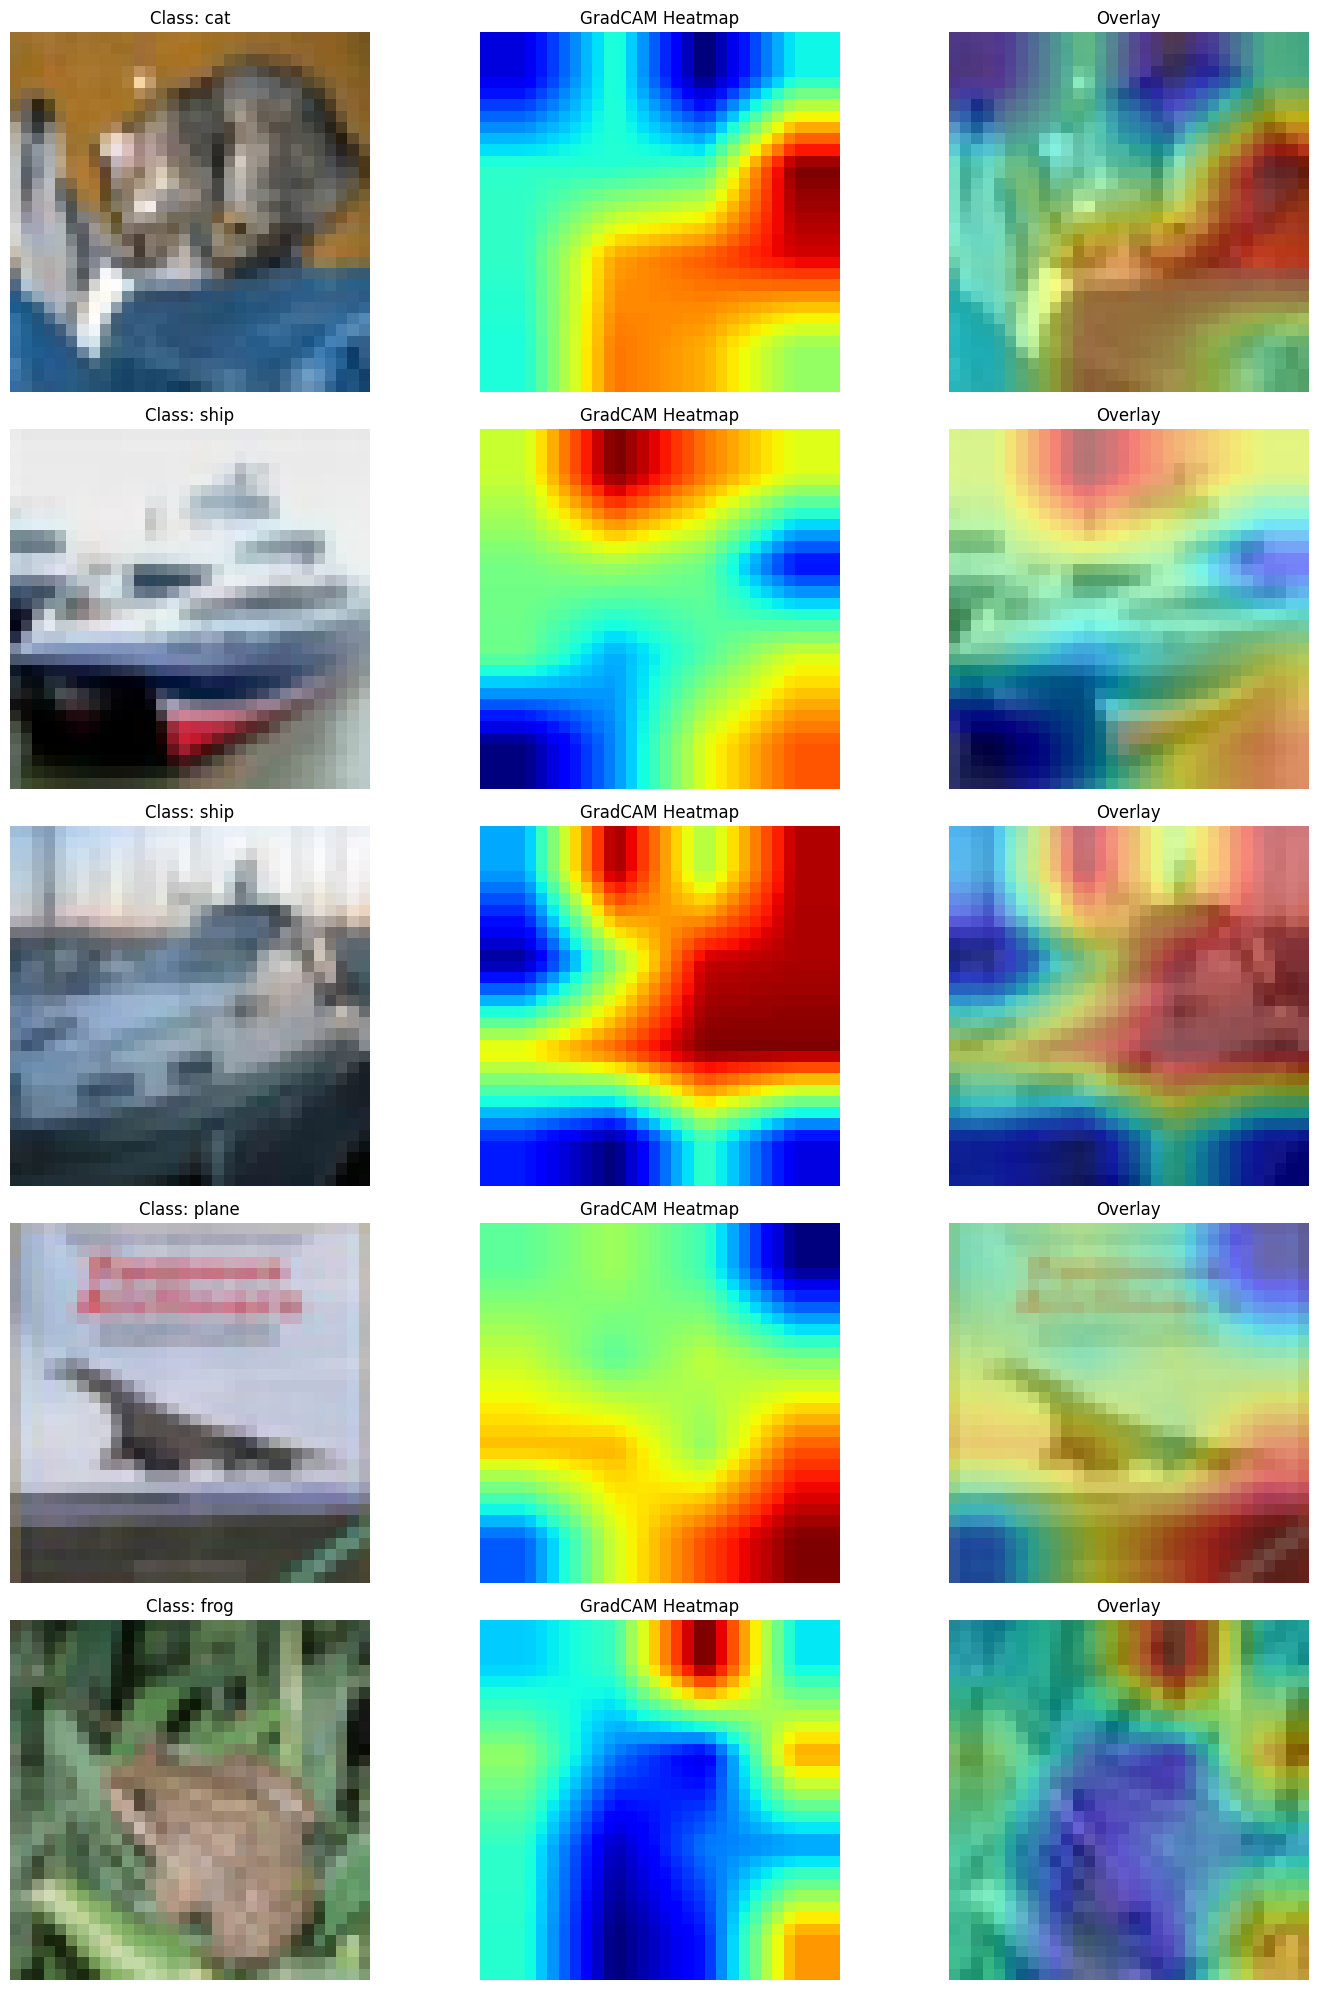

Step 3: Generating Class-Specific GradCAM Heatmaps
Generating new heatmaps


Generating class heatmaps:   2%|▏         | 11/625 [00:15<14:36,  1.43s/it]


Generated heatmaps: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Saved heatmaps to disk
Step 4: Initializing GAN Networks
Step 5: Training GAN with GradCAM Guidance


Epoch 1/10:   0%|          | 1/625 [00:02<27:53,  2.68s/it]

[1/10][0/625] Loss_D: 1.5946, Loss_G: 3.2627, GC: 1.0275


Epoch 1/10:   8%|▊         | 51/625 [01:35<13:39,  1.43s/it]

[1/10][50/625] Loss_D: 0.4212, Loss_G: 6.6315, GC: 0.9667


Epoch 1/10:  16%|█▌        | 101/625 [02:45<11:50,  1.36s/it]

[1/10][100/625] Loss_D: 0.2418, Loss_G: 6.9696, GC: 1.0083


Epoch 1/10:  21%|██        | 129/625 [03:27<12:05,  1.46s/it]/tmp/ipykernel_8551/346551886.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(img1_flat, img2_flat)
Epoch 1/10:  24%|██▍       | 151/625 [03:58<11:10,  1.41s/it]

[1/10][150/625] Loss_D: 0.5478, Loss_G: 4.6984, GC: 0.9479


Epoch 1/10:  32%|███▏      | 201/625 [05:21<11:25,  1.62s/it]

[1/10][200/625] Loss_D: 0.6012, Loss_G: 4.8400, GC: 0.9458


Epoch 1/10:  40%|████      | 251/625 [06:34<09:05,  1.46s/it]

[1/10][250/625] Loss_D: 0.2708, Loss_G: 6.0062, GC: 1.0116


Epoch 1/10:  48%|████▊     | 301/625 [07:48<07:54,  1.46s/it]

[1/10][300/625] Loss_D: 0.7268, Loss_G: 4.8721, GC: 1.0089


Epoch 1/10:  56%|█████▌    | 351/625 [09:06<06:16,  1.37s/it]

[1/10][350/625] Loss_D: 0.8587, Loss_G: 3.4417, GC: 0.9232


Epoch 1/10:  64%|██████▍   | 401/625 [10:28<07:20,  1.97s/it]

[1/10][400/625] Loss_D: 0.8121, Loss_G: 4.1404, GC: 0.9545


Epoch 1/10:  72%|███████▏  | 451/625 [12:10<06:57,  2.40s/it]

[1/10][450/625] Loss_D: 0.6358, Loss_G: 4.2500, GC: 0.8849


Epoch 1/10:  80%|████████  | 501/625 [13:33<03:03,  1.48s/it]

[1/10][500/625] Loss_D: 1.0423, Loss_G: 4.5677, GC: 0.9198


Epoch 1/10:  88%|████████▊ | 551/625 [14:47<01:34,  1.27s/it]

[1/10][550/625] Loss_D: 0.7580, Loss_G: 3.8925, GC: 0.9042


Epoch 1/10:  96%|█████████▌| 601/625 [16:02<00:52,  2.18s/it]

[1/10][600/625] Loss_D: 0.4687, Loss_G: 3.7517, GC: 0.9112


Epoch 1/10: 100%|██████████| 625/625 [16:40<00:00,  1.60s/it]

==> Epoch 1 TRAIN Losses | D: 0.7642 | G: 6.8502 | GC: 0.9154


==> Epoch 1 VAL | D: 0.9496 | G: 1.6443 | GC: 0.9352


Epoch 2/10:   0%|          | 1/625 [00:01<16:39,  1.60s/it]

[2/10][0/625] Loss_D: 0.5202, Loss_G: 4.3966, GC: 0.9105


Epoch 2/10:   8%|▊         | 51/625 [01:16<14:48,  1.55s/it]

[2/10][50/625] Loss_D: 0.3331, Loss_G: 4.4068, GC: 0.9751


Epoch 2/10:  16%|█▌        | 101/625 [02:39<14:13,  1.63s/it]

[2/10][100/625] Loss_D: 0.4565, Loss_G: 4.9781, GC: 0.9483


Epoch 2/10:  24%|██▍       | 151/625 [03:54<11:01,  1.40s/it]

[2/10][150/625] Loss_D: 0.4849, Loss_G: 3.9517, GC: 0.9492


Epoch 2/10:  32%|███▏      | 201/625 [05:06<10:06,  1.43s/it]

[2/10][200/625] Loss_D: 1.0857, Loss_G: 3.5079, GC: 0.9001


Epoch 2/10:  40%|████      | 251/625 [06:26<10:22,  1.66s/it]

[2/10][250/625] Loss_D: 0.7208, Loss_G: 3.5880, GC: 0.9230


Epoch 2/10:  48%|████▊     | 301/625 [07:41<08:16,  1.53s/it]

[2/10][300/625] Loss_D: 0.4063, Loss_G: 3.9655, GC: 0.9038


Epoch 2/10:  56%|█████▌    | 351/625 [08:58<06:52,  1.51s/it]

[2/10][350/625] Loss_D: 0.8075, Loss_G: 2.4235, GC: 0.9761


Epoch 2/10:  64%|██████▍   | 401/625 [10:19<06:07,  1.64s/it]

[2/10][400/625] Loss_D: 0.7032, Loss_G: 4.8633, GC: 0.9155


Epoch 2/10:  72%|███████▏  | 451/625 [11:31<04:16,  1.47s/it]

[2/10][450/625] Loss_D: 1.3077, Loss_G: 5.9020, GC: 0.9321


Epoch 2/10:  80%|████████  | 501/625 [12:50<03:01,  1.46s/it]

[2/10][500/625] Loss_D: 0.9221, Loss_G: 2.8444, GC: 0.8875


Epoch 2/10:  88%|████████▊ | 551/625 [14:06<01:51,  1.50s/it]

[2/10][550/625] Loss_D: 0.4816, Loss_G: 3.5515, GC: 0.9167


Epoch 2/10:  96%|█████████▌| 601/625 [15:22<00:36,  1.50s/it]

[2/10][600/625] Loss_D: 0.6311, Loss_G: 3.6498, GC: 0.9343


Epoch 2/10: 100%|██████████| 625/625 [15:56<00:00,  1.53s/it]

==> Epoch 2 TRAIN Losses | D: 0.9528 | G: 3.3566 | GC: 0.9372


==> Epoch 2 VAL | D: 1.1923 | G: 1.3617 | GC: 0.9373


Epoch 3/10:   0%|          | 1/625 [00:01<18:54,  1.82s/it]

[3/10][0/625] Loss_D: 0.5952, Loss_G: 2.6826, GC: 0.8937


Epoch 3/10:   8%|▊         | 51/625 [01:21<13:55,  1.46s/it]

[3/10][50/625] Loss_D: 0.6028, Loss_G: 3.3937, GC: 0.9453


Epoch 3/10:  16%|█▌        | 101/625 [02:35<11:31,  1.32s/it]

[3/10][100/625] Loss_D: 0.7519, Loss_G: 3.0634, GC: 0.9328


Epoch 3/10:  24%|██▍       | 151/625 [03:50<12:21,  1.57s/it]

[3/10][150/625] Loss_D: 0.5056, Loss_G: 4.1258, GC: 0.9203


Epoch 3/10:  32%|███▏      | 201/625 [05:13<09:46,  1.38s/it]

[3/10][200/625] Loss_D: 0.4676, Loss_G: 4.3086, GC: 0.9177


Epoch 3/10:  40%|████      | 251/625 [06:26<09:32,  1.53s/it]

[3/10][250/625] Loss_D: 0.3798, Loss_G: 4.2783, GC: 0.9052


Epoch 3/10:  48%|████▊     | 301/625 [07:32<08:11,  1.52s/it]

[3/10][300/625] Loss_D: 0.5796, Loss_G: 4.0545, GC: 0.9623


Epoch 3/10:  56%|█████▌    | 351/625 [08:52<07:35,  1.66s/it]

[3/10][350/625] Loss_D: 0.5485, Loss_G: 2.5167, GC: 0.9415


Epoch 3/10:  64%|██████▍   | 401/625 [10:04<05:14,  1.40s/it]

[3/10][400/625] Loss_D: 0.8918, Loss_G: 5.0645, GC: 0.9006


Epoch 3/10:  72%|███████▏  | 451/625 [11:22<04:17,  1.48s/it]

[3/10][450/625] Loss_D: 1.1518, Loss_G: 3.9703, GC: 0.9476


Epoch 3/10:  80%|████████  | 501/625 [12:53<05:14,  2.54s/it]

[3/10][500/625] Loss_D: 0.5046, Loss_G: 3.6586, GC: 0.9592


Epoch 3/10:  88%|████████▊ | 551/625 [14:50<02:12,  1.80s/it]

[3/10][550/625] Loss_D: 0.8622, Loss_G: 3.3202, GC: 0.9102


Epoch 3/10:  96%|█████████▌| 601/625 [16:21<00:41,  1.72s/it]

[3/10][600/625] Loss_D: 0.8185, Loss_G: 3.2353, GC: 0.9230


Epoch 3/10: 100%|██████████| 625/625 [17:05<00:00,  1.64s/it]

==> Epoch 3 TRAIN Losses | D: 0.7716 | G: 3.9468 | GC: 0.9396


==> Epoch 3 VAL | D: 0.9324 | G: 1.8409 | GC: 0.9237


Epoch 4/10:   0%|          | 1/625 [00:01<18:15,  1.76s/it]

[4/10][0/625] Loss_D: 0.4402, Loss_G: 4.5128, GC: 0.9256


Epoch 4/10:   8%|▊         | 51/625 [01:36<19:30,  2.04s/it]

[4/10][50/625] Loss_D: 0.6147, Loss_G: 3.1553, GC: 0.9386


Epoch 4/10:  16%|█▌        | 101/625 [03:16<16:35,  1.90s/it]

[4/10][100/625] Loss_D: 0.5415, Loss_G: 3.4606, GC: 0.9353


Epoch 4/10:  24%|██▍       | 151/625 [04:52<15:12,  1.92s/it]

[4/10][150/625] Loss_D: 0.8049, Loss_G: 3.5768, GC: 0.9182


Epoch 4/10:  32%|███▏      | 201/625 [06:28<14:00,  1.98s/it]

[4/10][200/625] Loss_D: 0.7115, Loss_G: 3.0736, GC: 0.9135


Epoch 4/10:  40%|████      | 251/625 [08:00<11:15,  1.81s/it]

[4/10][250/625] Loss_D: 1.2070, Loss_G: 4.3497, GC: 0.9184


Epoch 4/10:  48%|████▊     | 301/625 [09:36<10:24,  1.93s/it]

[4/10][300/625] Loss_D: 0.8762, Loss_G: 2.4754, GC: 0.9152


Epoch 4/10:  56%|█████▌    | 351/625 [11:09<07:41,  1.69s/it]

[4/10][350/625] Loss_D: 0.7717, Loss_G: 4.5002, GC: 0.9202


Epoch 4/10:  64%|██████▍   | 401/625 [12:24<05:24,  1.45s/it]

[4/10][400/625] Loss_D: 0.8024, Loss_G: 4.0193, GC: 0.9042


Epoch 4/10:  72%|███████▏  | 451/625 [13:37<04:18,  1.49s/it]

[4/10][450/625] Loss_D: 0.8232, Loss_G: 2.8176, GC: 0.9103


Epoch 4/10:  80%|████████  | 501/625 [14:48<03:11,  1.54s/it]

[4/10][500/625] Loss_D: 0.9423, Loss_G: 2.7215, GC: 0.9358


Epoch 4/10:  88%|████████▊ | 551/625 [16:07<02:22,  1.93s/it]

[4/10][550/625] Loss_D: 0.6347, Loss_G: 2.9890, GC: 0.9080


Epoch 4/10:  96%|█████████▌| 601/625 [17:40<00:37,  1.58s/it]

[4/10][600/625] Loss_D: 0.7633, Loss_G: 2.6725, GC: 0.9394


Epoch 4/10: 100%|██████████| 625/625 [18:22<00:00,  1.76s/it]

==> Epoch 4 TRAIN Losses | D: 0.7386 | G: 2.7107 | GC: 0.9539


==> Epoch 4 VAL | D: 1.1013 | G: 1.1965 | GC: 0.9363


Epoch 5/10:   0%|          | 1/625 [00:01<14:42,  1.41s/it]

[5/10][0/625] Loss_D: 0.6717, Loss_G: 3.5378, GC: 0.9244


Epoch 5/10:   8%|▊         | 51/625 [01:10<12:45,  1.33s/it]

[5/10][50/625] Loss_D: 0.7300, Loss_G: 3.3537, GC: 0.9322


Epoch 5/10:  16%|█▌        | 101/625 [02:21<12:01,  1.38s/it]

[5/10][100/625] Loss_D: 0.7752, Loss_G: 3.5617, GC: 0.9653


Epoch 5/10:  24%|██▍       | 151/625 [03:37<10:51,  1.37s/it]

[5/10][150/625] Loss_D: 1.1168, Loss_G: 3.6228, GC: 0.8844


Epoch 5/10:  32%|███▏      | 201/625 [04:53<10:35,  1.50s/it]

[5/10][200/625] Loss_D: 0.6492, Loss_G: 3.3934, GC: 0.9262


Epoch 5/10:  40%|████      | 251/625 [06:10<09:06,  1.46s/it]

[5/10][250/625] Loss_D: 0.7247, Loss_G: 3.3423, GC: 0.9543


Epoch 5/10:  48%|████▊     | 301/625 [07:27<08:13,  1.52s/it]

[5/10][300/625] Loss_D: 0.6398, Loss_G: 2.7092, GC: 0.9206


Epoch 5/10:  56%|█████▌    | 351/625 [09:00<10:18,  2.26s/it]

[5/10][350/625] Loss_D: 0.8125, Loss_G: 2.8520, GC: 0.9259


Epoch 5/10:  64%|██████▍   | 401/625 [10:41<07:19,  1.96s/it]

[5/10][400/625] Loss_D: 1.1641, Loss_G: 2.8036, GC: 0.9144


Epoch 5/10:  72%|███████▏  | 451/625 [12:33<05:39,  1.95s/it]

[5/10][450/625] Loss_D: 0.6480, Loss_G: 3.1771, GC: 0.9719


Epoch 5/10:  80%|████████  | 501/625 [14:21<04:06,  1.99s/it]

[5/10][500/625] Loss_D: 0.9497, Loss_G: 2.8415, GC: 0.9401


Epoch 5/10:  88%|████████▊ | 551/625 [16:05<02:29,  2.03s/it]

[5/10][550/625] Loss_D: 1.6187, Loss_G: 2.1504, GC: 0.9311


Epoch 5/10:  96%|█████████▌| 601/625 [17:49<00:48,  2.02s/it]

[5/10][600/625] Loss_D: 0.8256, Loss_G: 2.8791, GC: 0.9368


Epoch 5/10: 100%|██████████| 625/625 [18:38<00:00,  1.79s/it]

==> Epoch 5 TRAIN Losses | D: 0.9592 | G: 1.7922 | GC: 0.9336


==> Epoch 5 VAL | D: 1.4466 | G: 0.6710 | GC: 0.9305
Saved samples at epoch 5


Epoch 6/10:   0%|          | 1/625 [00:02<26:26,  2.54s/it]

[6/10][0/625] Loss_D: 0.8425, Loss_G: 3.7853, GC: 0.9009


Epoch 6/10:   8%|▊         | 51/625 [01:44<21:04,  2.20s/it]

[6/10][50/625] Loss_D: 1.0770, Loss_G: 3.5045, GC: 0.9271


Epoch 6/10:  16%|█▌        | 101/625 [03:33<18:43,  2.14s/it]

[6/10][100/625] Loss_D: 1.3008, Loss_G: 3.1238, GC: 0.9437


Epoch 6/10:  24%|██▍       | 151/625 [05:28<17:11,  2.18s/it]

[6/10][150/625] Loss_D: 0.5315, Loss_G: 3.1705, GC: 0.9287


Epoch 6/10:  32%|███▏      | 201/625 [07:18<16:48,  2.38s/it]

[6/10][200/625] Loss_D: 1.0320, Loss_G: 2.7811, GC: 0.9224


Epoch 6/10:  40%|████      | 251/625 [09:11<12:00,  1.93s/it]

[6/10][250/625] Loss_D: 0.9134, Loss_G: 2.8741, GC: 0.9384


Epoch 6/10:  48%|████▊     | 301/625 [10:34<09:19,  1.73s/it]

[6/10][300/625] Loss_D: 0.9732, Loss_G: 2.7676, GC: 0.9225


Epoch 6/10:  56%|█████▌    | 351/625 [12:04<07:51,  1.72s/it]

[6/10][350/625] Loss_D: 0.6675, Loss_G: 2.7945, GC: 0.9444


Epoch 6/10:  64%|██████▍   | 401/625 [13:31<08:50,  2.37s/it]

[6/10][400/625] Loss_D: 0.8683, Loss_G: 3.2705, GC: 0.9189


Epoch 6/10:  72%|███████▏  | 451/625 [15:21<05:55,  2.04s/it]

[6/10][450/625] Loss_D: 0.6016, Loss_G: 3.1515, GC: 0.9259


Epoch 6/10:  80%|████████  | 501/625 [17:09<04:13,  2.04s/it]

[6/10][500/625] Loss_D: 0.5603, Loss_G: 2.9599, GC: 0.9650


Epoch 6/10:  88%|████████▊ | 551/625 [18:55<02:14,  1.82s/it]

[6/10][550/625] Loss_D: 1.0162, Loss_G: 2.8018, GC: 0.9297


Epoch 6/10:  96%|█████████▌| 601/625 [20:47<00:54,  2.28s/it]

[6/10][600/625] Loss_D: 1.0821, Loss_G: 2.3531, GC: 0.9473


Epoch 6/10: 100%|██████████| 625/625 [21:38<00:00,  2.08s/it]

==> Epoch 6 TRAIN Losses | D: 0.8771 | G: 2.4160 | GC: 0.9006


==> Epoch 6 VAL | D: 1.0222 | G: 1.1274 | GC: 0.9240


Epoch 7/10:   0%|          | 1/625 [00:02<28:00,  2.69s/it]

[7/10][0/625] Loss_D: 1.0281, Loss_G: 2.4631, GC: 0.9530


Epoch 7/10:   8%|▊         | 51/625 [01:55<15:33,  1.63s/it]

[7/10][50/625] Loss_D: 0.9460, Loss_G: 2.4581, GC: 0.9071


Epoch 7/10:  16%|█▌        | 101/625 [03:02<10:16,  1.18s/it]

[7/10][100/625] Loss_D: 0.5980, Loss_G: 2.8413, GC: 0.9993


Epoch 7/10:  24%|██▍       | 151/625 [04:16<09:28,  1.20s/it]

[7/10][150/625] Loss_D: 0.9093, Loss_G: 4.0378, GC: 0.9480


Epoch 7/10:  32%|███▏      | 201/625 [06:05<14:51,  2.10s/it]

[7/10][200/625] Loss_D: 0.8158, Loss_G: 2.0660, GC: 0.9509


Epoch 7/10:  40%|████      | 251/625 [08:04<14:20,  2.30s/it]

[7/10][250/625] Loss_D: 0.6342, Loss_G: 2.8810, GC: 0.8889


Epoch 7/10:  48%|████▊     | 301/625 [10:01<13:28,  2.50s/it]

[7/10][300/625] Loss_D: 0.6172, Loss_G: 2.8335, GC: 0.9243


Epoch 7/10:  56%|█████▌    | 351/625 [12:05<10:19,  2.26s/it]

[7/10][350/625] Loss_D: 0.8070, Loss_G: 2.9494, GC: 0.9415


Epoch 7/10:  64%|██████▍   | 401/625 [14:06<09:26,  2.53s/it]

[7/10][400/625] Loss_D: 0.5875, Loss_G: 2.8557, GC: 0.9416


Epoch 7/10:  72%|███████▏  | 451/625 [15:53<05:32,  1.91s/it]

[7/10][450/625] Loss_D: 1.0749, Loss_G: 2.8437, GC: 0.9475


Epoch 7/10:  80%|████████  | 501/625 [17:40<04:09,  2.02s/it]

[7/10][500/625] Loss_D: 0.6813, Loss_G: 3.7814, GC: 0.9692


Epoch 7/10:  88%|████████▊ | 551/625 [19:28<02:19,  1.88s/it]

[7/10][550/625] Loss_D: 2.1049, Loss_G: 1.4735, GC: 0.9374


Epoch 7/10:  96%|█████████▌| 601/625 [21:13<00:53,  2.22s/it]

[7/10][600/625] Loss_D: 0.8980, Loss_G: 3.4299, GC: 0.9162


Epoch 7/10: 100%|██████████| 625/625 [22:08<00:00,  2.13s/it]

==> Epoch 7 TRAIN Losses | D: 0.5785 | G: 3.0507 | GC: 0.9376


==> Epoch 7 VAL | D: 1.1340 | G: 1.3255 | GC: 0.9338


Epoch 8/10:   0%|          | 1/625 [00:01<18:33,  1.78s/it]

[8/10][0/625] Loss_D: 0.5525, Loss_G: 2.5285, GC: 0.9441


Epoch 8/10:   8%|▊         | 51/625 [01:41<13:24,  1.40s/it]

[8/10][50/625] Loss_D: 0.6481, Loss_G: 3.0394, GC: 0.9486


Epoch 8/10:  16%|█▌        | 101/625 [03:33<19:46,  2.26s/it]

[8/10][100/625] Loss_D: 0.5105, Loss_G: 2.8470, GC: 0.9558


Epoch 8/10:  24%|██▍       | 151/625 [05:20<16:33,  2.10s/it]

[8/10][150/625] Loss_D: 1.2457, Loss_G: 3.9634, GC: 0.9114


Epoch 8/10:  32%|███▏      | 201/625 [07:07<15:02,  2.13s/it]

[8/10][200/625] Loss_D: 1.1241, Loss_G: 1.3519, GC: 0.9305


Epoch 8/10:  40%|████      | 251/625 [08:54<10:12,  1.64s/it]

[8/10][250/625] Loss_D: 0.6508, Loss_G: 2.7625, GC: 0.9073


Epoch 8/10:  48%|████▊     | 301/625 [10:45<13:01,  2.41s/it]

[8/10][300/625] Loss_D: 0.8209, Loss_G: 3.1939, GC: 0.9462


Epoch 8/10:  56%|█████▌    | 351/625 [12:33<09:18,  2.04s/it]

[8/10][350/625] Loss_D: 0.6973, Loss_G: 2.7272, GC: 0.9249


Epoch 8/10:  64%|██████▍   | 401/625 [14:30<08:30,  2.28s/it]

[8/10][400/625] Loss_D: 0.5217, Loss_G: 3.2913, GC: 0.9202


Epoch 8/10:  72%|███████▏  | 451/625 [16:20<06:37,  2.28s/it]

[8/10][450/625] Loss_D: 0.8274, Loss_G: 2.8236, GC: 0.9486


Epoch 8/10:  80%|████████  | 501/625 [18:04<04:12,  2.04s/it]

[8/10][500/625] Loss_D: 0.7776, Loss_G: 2.7012, GC: 0.9375


Epoch 8/10:  88%|████████▊ | 551/625 [19:26<01:56,  1.58s/it]

[8/10][550/625] Loss_D: 1.0398, Loss_G: 2.0960, GC: 0.9375


Epoch 8/10:  96%|█████████▌| 601/625 [20:50<00:38,  1.62s/it]

[8/10][600/625] Loss_D: 0.6428, Loss_G: 3.2611, GC: 0.9444


Epoch 8/10: 100%|██████████| 625/625 [21:28<00:00,  2.06s/it]

==> Epoch 8 TRAIN Losses | D: 0.6495 | G: 2.7400 | GC: 0.8980


==> Epoch 8 VAL | D: 1.1815 | G: 1.3458 | GC: 0.9291


Epoch 9/10:   0%|          | 1/625 [00:01<16:43,  1.61s/it]

[9/10][0/625] Loss_D: 0.7050, Loss_G: 2.8142, GC: 0.8974


Epoch 9/10:   8%|▊         | 51/625 [01:26<18:09,  1.90s/it]

[9/10][50/625] Loss_D: 1.0560, Loss_G: 3.0252, GC: 0.9191


Epoch 9/10:  16%|█▌        | 101/625 [02:52<19:28,  2.23s/it]

[9/10][100/625] Loss_D: 1.0385, Loss_G: 1.9737, GC: 0.9220


Epoch 9/10:  24%|██▍       | 151/625 [04:17<11:47,  1.49s/it]

[9/10][150/625] Loss_D: 0.9086, Loss_G: 2.5380, GC: 0.9200


Epoch 9/10:  32%|███▏      | 201/625 [05:37<11:58,  1.69s/it]

[9/10][200/625] Loss_D: 1.0859, Loss_G: 2.1343, GC: 0.9228


Epoch 9/10:  40%|████      | 251/625 [07:02<11:43,  1.88s/it]

[9/10][250/625] Loss_D: 0.5963, Loss_G: 3.6774, GC: 0.9526


Epoch 9/10:  48%|████▊     | 301/625 [08:21<08:30,  1.58s/it]

[9/10][300/625] Loss_D: 0.6176, Loss_G: 2.7348, GC: 0.9280


Epoch 9/10:  56%|█████▌    | 351/625 [09:43<07:01,  1.54s/it]

[9/10][350/625] Loss_D: 0.7085, Loss_G: 3.0473, GC: 0.9487


Epoch 9/10:  64%|██████▍   | 401/625 [11:02<05:50,  1.57s/it]

[9/10][400/625] Loss_D: 0.7675, Loss_G: 2.9286, GC: 0.9230


Epoch 9/10:  72%|███████▏  | 451/625 [12:21<04:45,  1.64s/it]

[9/10][450/625] Loss_D: 0.6523, Loss_G: 2.7902, GC: 0.9182


Epoch 9/10:  80%|████████  | 501/625 [13:42<03:11,  1.55s/it]

[9/10][500/625] Loss_D: 0.6525, Loss_G: 3.2831, GC: 0.9345


Epoch 9/10:  88%|████████▊ | 551/625 [15:21<02:17,  1.86s/it]

[9/10][550/625] Loss_D: 0.9095, Loss_G: 3.3722, GC: 0.9329


Epoch 9/10:  96%|█████████▌| 601/625 [17:28<00:59,  2.49s/it]

[9/10][600/625] Loss_D: 0.8643, Loss_G: 2.9531, GC: 0.9471


Epoch 9/10: 100%|██████████| 625/625 [18:25<00:00,  1.77s/it]

==> Epoch 9 TRAIN Losses | D: 0.6737 | G: 2.8750 | GC: 0.9533


==> Epoch 9 VAL | D: 1.2133 | G: 1.1058 | GC: 0.9420


Epoch 10/10:   0%|          | 1/625 [00:01<16:17,  1.57s/it]

[10/10][0/625] Loss_D: 0.5308, Loss_G: 3.8573, GC: 0.9550


Epoch 10/10:   8%|▊         | 51/625 [02:00<23:23,  2.45s/it]

[10/10][50/625] Loss_D: 0.7871, Loss_G: 4.3958, GC: 0.9244


Epoch 10/10:  16%|█▌        | 101/625 [04:06<21:58,  2.52s/it]

[10/10][100/625] Loss_D: 0.6849, Loss_G: 2.4930, GC: 0.9559


Epoch 10/10:  24%|██▍       | 151/625 [05:48<17:21,  2.20s/it]

[10/10][150/625] Loss_D: 0.7316, Loss_G: 3.8003, GC: 0.9504


Epoch 10/10:  32%|███▏      | 201/625 [07:44<13:00,  1.84s/it]

[10/10][200/625] Loss_D: 1.1052, Loss_G: 1.8730, GC: 0.9589


Epoch 10/10:  40%|████      | 251/625 [09:45<13:46,  2.21s/it]

[10/10][250/625] Loss_D: 0.8540, Loss_G: 3.0121, GC: 0.9300


Epoch 10/10:  48%|████▊     | 301/625 [11:32<13:31,  2.51s/it]

[10/10][300/625] Loss_D: 0.7343, Loss_G: 2.3139, GC: 0.9237


Epoch 10/10:  56%|█████▌    | 351/625 [13:30<08:09,  1.79s/it]

[10/10][350/625] Loss_D: 0.6615, Loss_G: 3.1200, GC: 0.9401


Epoch 10/10:  64%|██████▍   | 401/625 [14:57<04:50,  1.30s/it]

[10/10][400/625] Loss_D: 0.9756, Loss_G: 2.4398, GC: 0.9074


Epoch 10/10:  72%|███████▏  | 451/625 [16:55<06:37,  2.28s/it]

[10/10][450/625] Loss_D: 0.6551, Loss_G: 2.6175, GC: 0.9617


Epoch 10/10:  80%|████████  | 501/625 [18:55<04:50,  2.35s/it]

[10/10][500/625] Loss_D: 0.6548, Loss_G: 3.1369, GC: 0.9425


Epoch 10/10:  88%|████████▊ | 551/625 [20:44<03:08,  2.54s/it]

[10/10][550/625] Loss_D: 0.8148, Loss_G: 2.3871, GC: 0.9100


Epoch 10/10:  96%|█████████▌| 601/625 [22:20<00:55,  2.30s/it]

[10/10][600/625] Loss_D: 0.8436, Loss_G: 3.1716, GC: 0.9360


Epoch 10/10: 100%|██████████| 625/625 [23:13<00:00,  2.23s/it]

==> Epoch 10 TRAIN Losses | D: 1.5190 | G: 5.1295 | GC: 0.9390


==> Epoch 10 VAL | D: 1.5049 | G: 2.0688 | GC: 0.9396
Saved samples at epoch 10


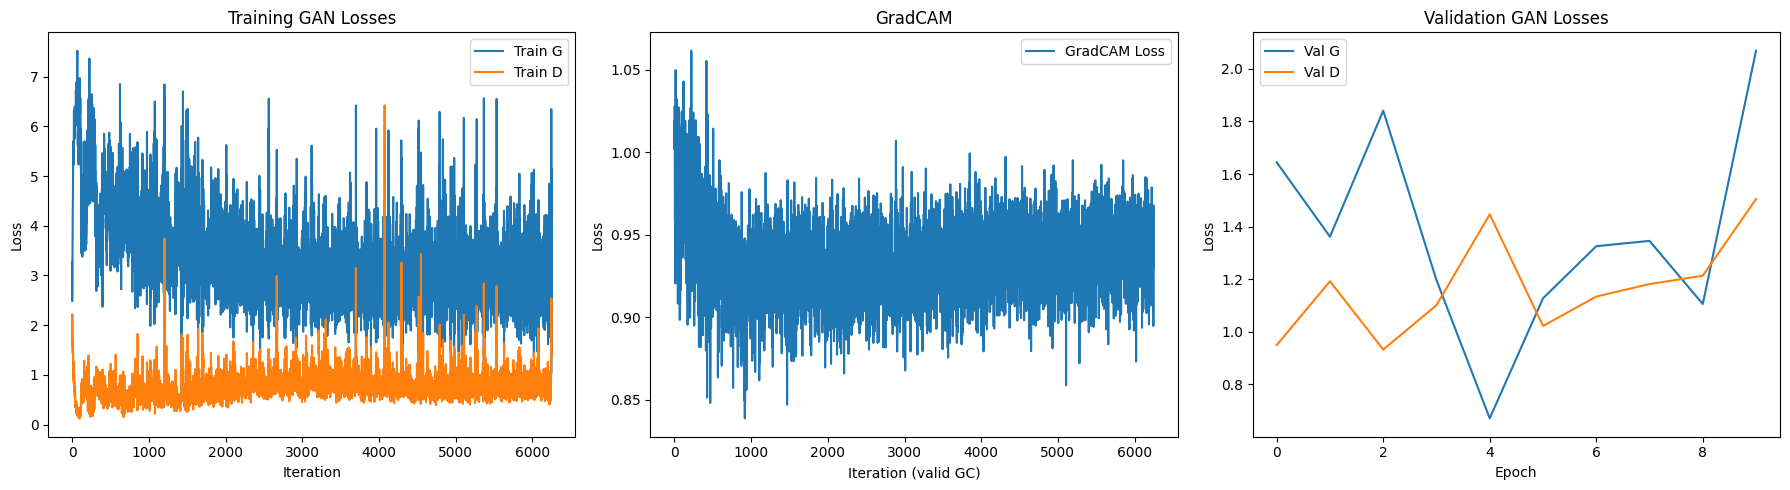

Step 6: Evaluating GAN with GradCAM


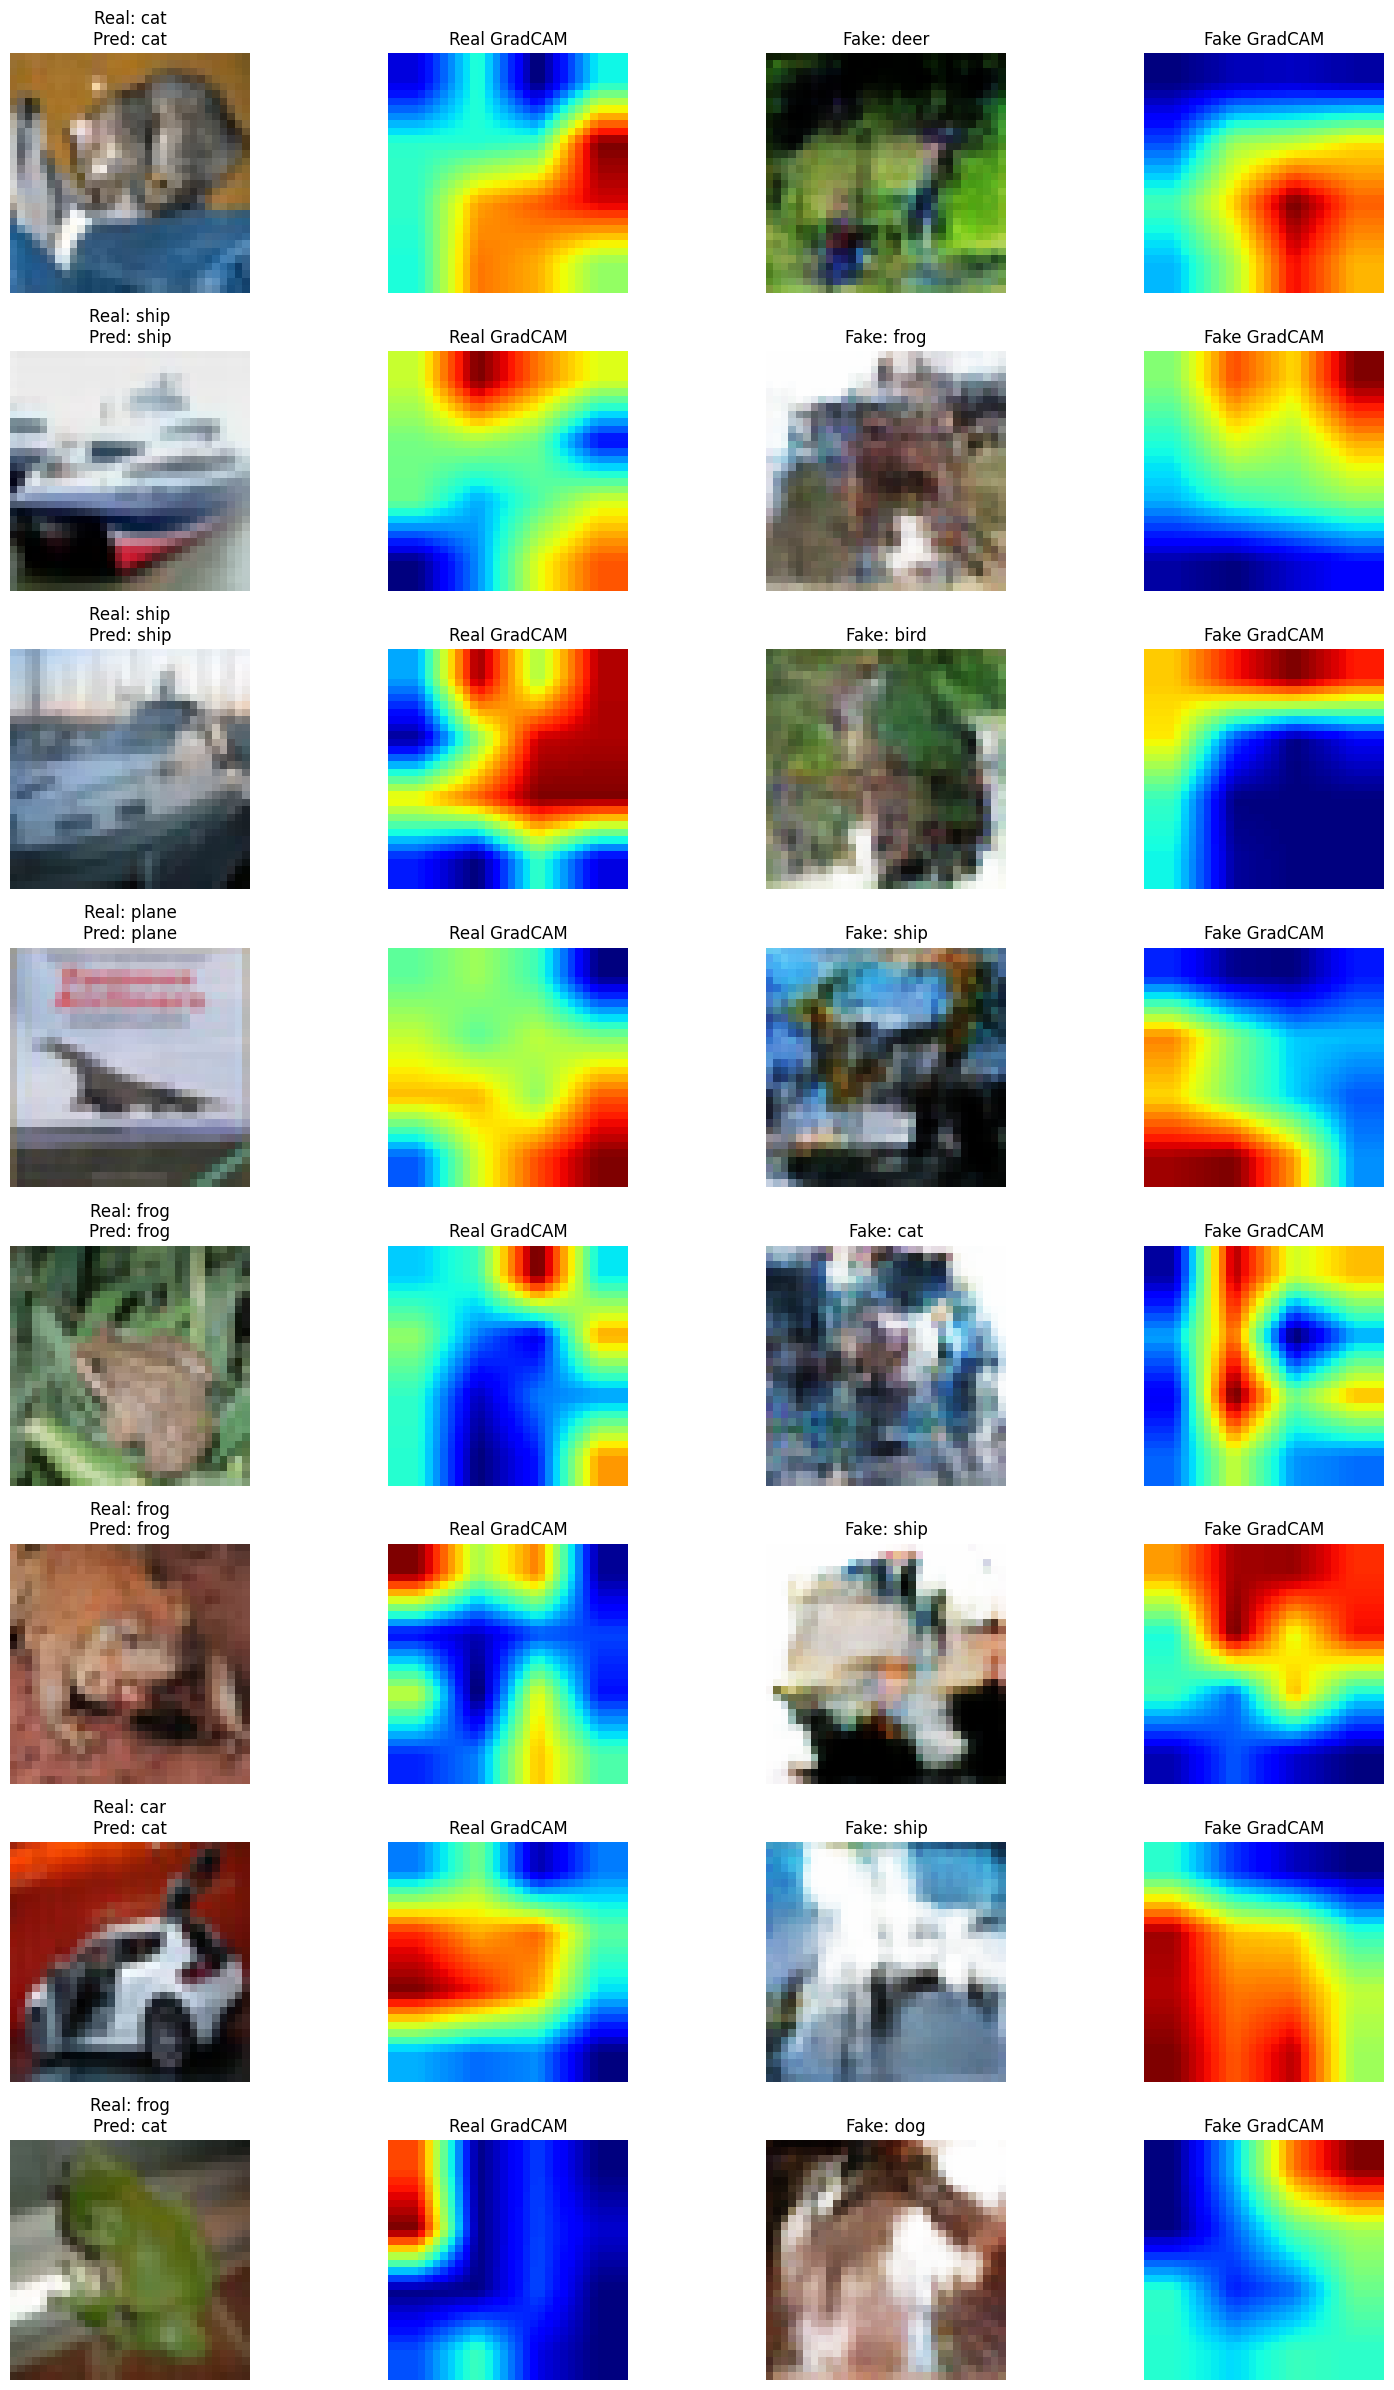

SSIM: Mean = 0.0818, Std = 0.1133
Pearson Correlation: Mean = -0.0233, Std = 0.3219


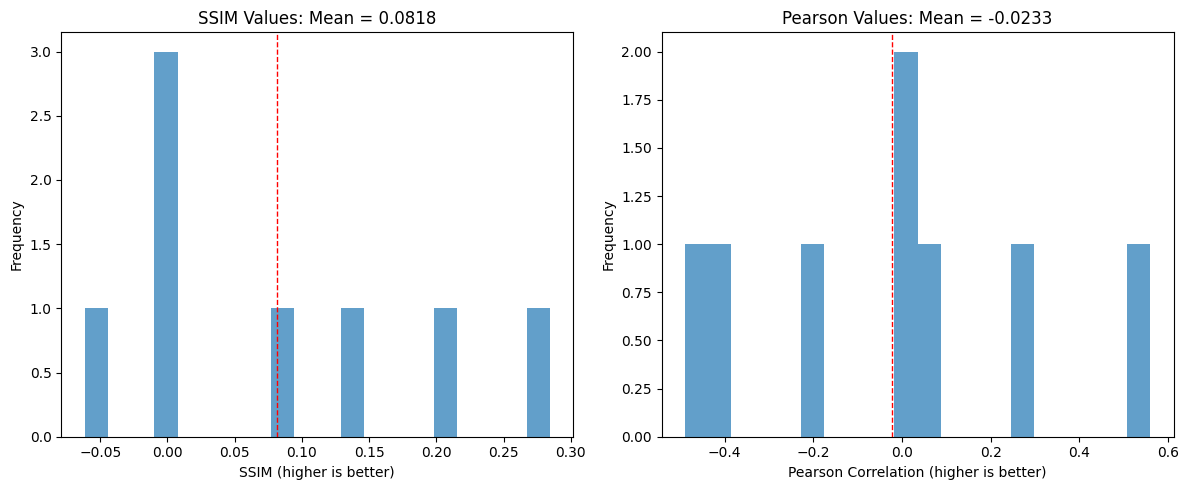

Step 7: Generating Final Samples


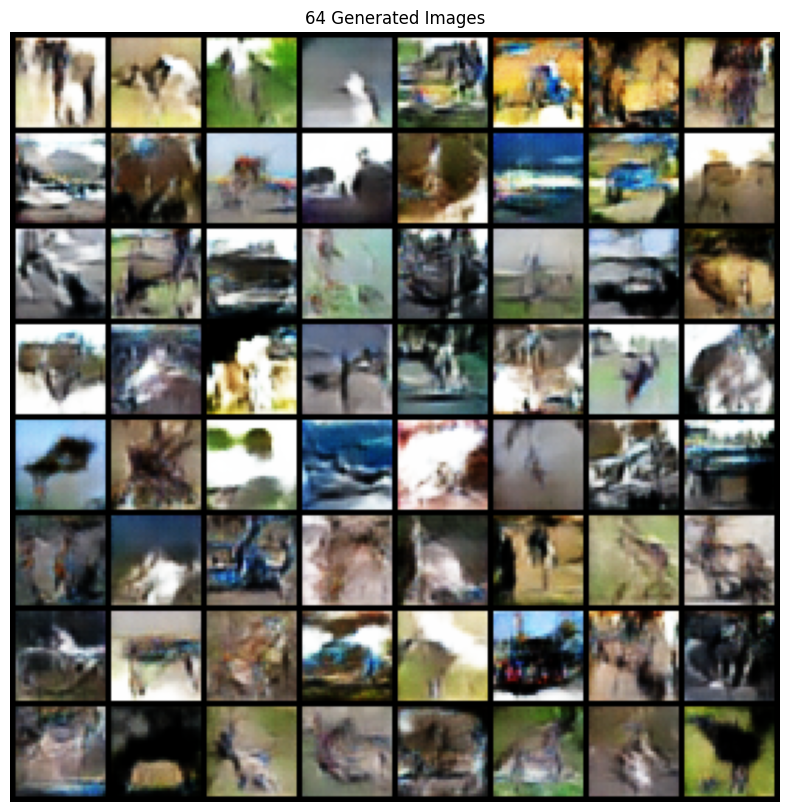

All steps completed!


In [13]:
main()